# Project : Walmart TripType Classification


# 1. Data Introduce
### 1.1 Purpose : Use market basket analysis to classify shopping trips
    

### 1.2 Data set:
   > - Train Data : 647054 rows, 7 columns

   > - Test Data  : 653646 rows, 6 columns
   
   > - Submission Data  : 95674 rows, 39 columns
      
   > - [Source Link : Walmart TripType : Recruiting-trip-type-classification](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification)

### 1.3 Evaluation
   > - multi-class logarithmic loss
   > $$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$


### 1.4 Results
#### (1) Train-test outcome
   > - Logarithmic loss : 
   > - Accuracy score : 
#### (2) Kaggle submission
   > - Total Teams : 
   > - Final Score : 
   > - Leaderboard :  
   

### 1.5 Contents
#### (1) Data Format
   > - Column Description
   > - Visualization
#### (2) Feature Engineering
   > - Columns what we made
#### (3) Modeling
   > - The model we tried
   > - The model we ultimately used
#### (4) Feedback 
   > - Question

# Data Format

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Markdown

# Import the functions used in this project
import awesome_functions as af
import decode_utils as du
from feature_engineering import *  

# Pretty display for notebooks
%matplotlib inline

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

import lightgbm
from scipy.sparse import csr_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df_train = pd.read_csv("../asset/train.csv")
df_test = pd.read_csv("../asset/test.csv")
df_submission = pd.read_csv("../asset/sample_submission.csv")

In [3]:
train = pd.read_csv('new_Exploration/train.csv')
test = pd.read_csv('new_Exploration/test.csv')
submission = pd.read_csv('new_Exploration/sample_submission.csv')

In [4]:
display(Markdown('## Train DataFrame'))
display(train.tail())
display(Markdown('## Test DataFrame'))
display(test.tail())

## Train DataFrame

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


## Test DataFrame

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
653641,191348,Sunday,6.657211e+10,1,BATH AND SHOWER,1505.0
653642,191348,Sunday,8.818139e+10,1,BATH AND SHOWER,1099.0
653643,191348,Sunday,4.282557e+09,1,MENS WEAR,8220.0
653644,191348,Sunday,8.046919e+10,1,SWIMWEAR/OUTERWEAR,114.0
653645,191348,Sunday,7.871536e+09,1,MENS WEAR,4923.0


## Brief Column Description
   > - TripType :  구매자의 구매 활동을 대표하는 카테고리성 아이디, 라벨값을 의미한다.
   
   > - VisitNumber : 단일 구매자의 단일 구매 활동을 대표하는 아이디이다.
   
   > - Weekday :  구매활동을 한 요일을 의미한다.
   
   > - Upc : Universal Product Code 를 의미한다. 
   
   > - ScanCount : 해당 아이템을 몇 개를 샀는지에 대한 정보가 담겨져있다. 음수값은 반환을 의미한다.
   
   > - DepartmentDescription : 아이템 분류의 가장 높은 범주를 의미한다.
   
   > - FinelineNumber : 월마트에서 자체적으로 제공하는 더 세분화된 상품 분류 코드이다.

In [5]:
submission = pd.read_csv('new_Exploration/sample_submission.csv')
submission.tail()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
95669,191338,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191339,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95671,191340,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191341,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA

## Distribution of goods by TripType

In [6]:
train.tail()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


In [7]:
train_40 = train[train['TripType']==40]
train_40_groupby = train_40.groupby('DepartmentDescription',as_index=False)['ScanCount'].count()
train_40_groupby = train_40_groupby.sort_values('ScanCount',ascending=False)
train_39 = train[train['TripType']==39]
train_39_groupby = train_39.groupby('DepartmentDescription',as_index=False)['ScanCount'].count()
train_39_groupby = train_39_groupby.sort_values('ScanCount',ascending=False)

Text(0.5,1,'Distribution of DD at TripType = 40')

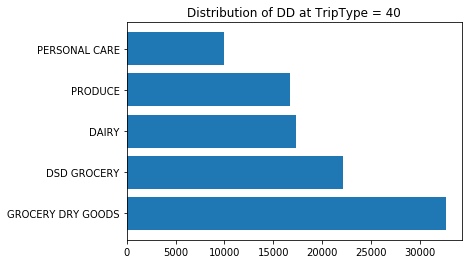

In [235]:
import matplotlib.pyplot as plt
plt.barh((train_40_groupby['DepartmentDescription'][:5]) , (train_40_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 40')

Text(0.5,1,'Distribution of DD at TripType = 39')

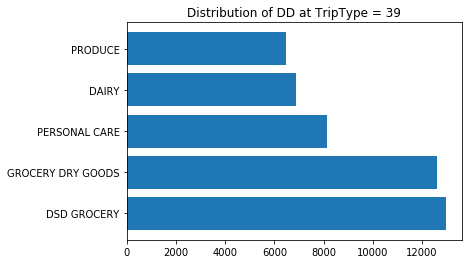

In [9]:
plt.barh((train_39_groupby['DepartmentDescription'][:5]) , (train_39_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 39')

#### 각각의 TripType은 각기 다른 DepartmentDescription 분포(특성) 를 띈다.

## TripType '999' indicating other items

In [10]:
train_tt_sc = train.groupby('TripType',as_index=False)['ScanCount'].sum()

/home/hskimim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hskimim/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


(-5000, 50000)

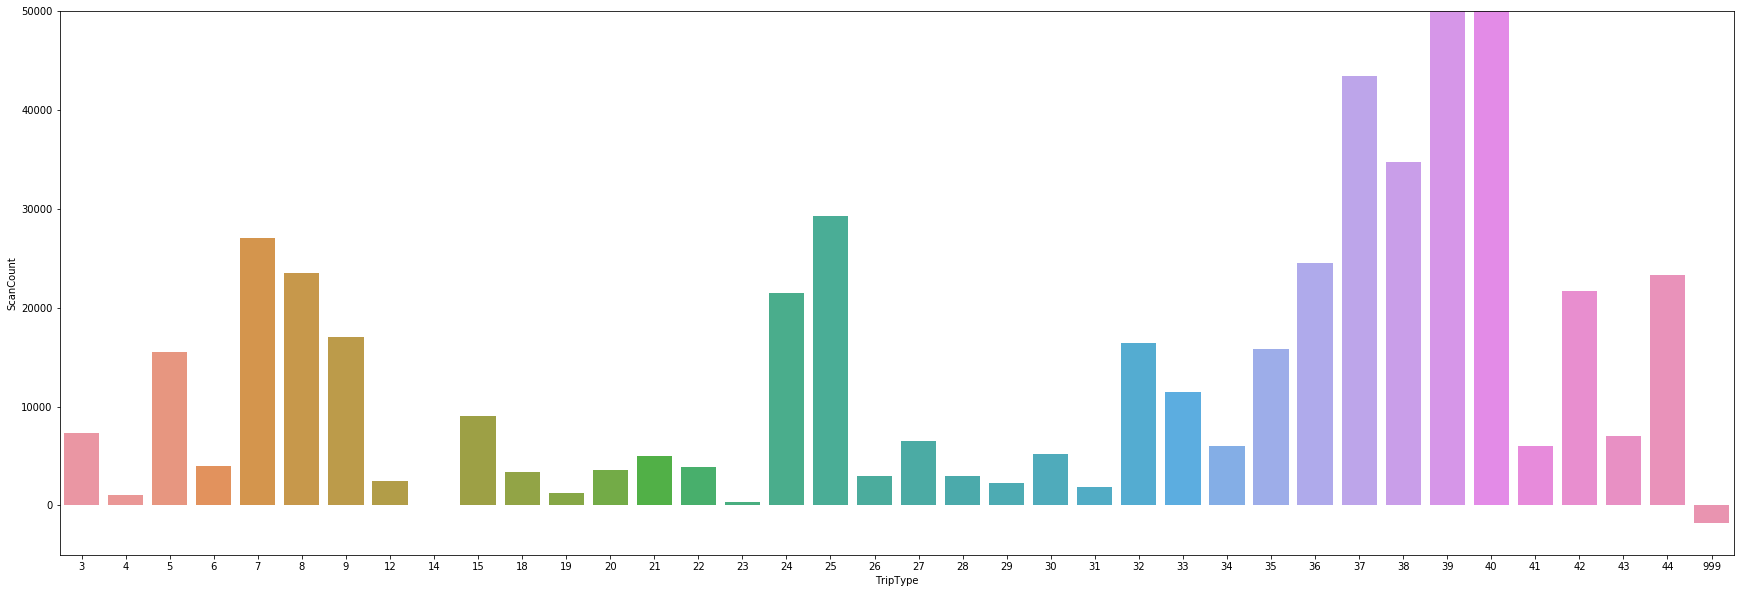

In [11]:
import seaborn as sns
plt.figure(figsize=(30,10))
sns.barplot(train_tt_sc['TripType'].astype('int') , train_tt_sc['ScanCount'])
plt.ylim(-5000,50000)

### TripType '999' 는 총 구매한 아이템의 수가 음수, 즉 최종 구매 활동이 `반환` 인 구매자를 의미한다.

## Deal with Missing value

In [16]:
train.isna().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [265]:
null_index = sorted(list(set(train[train['Upc'].isna()].index).intersection(set(train[train['FinelineNumber'].isna()].index))))
null_train_df = train.loc[null_index,:]#.reset_index(drop=True)

In [266]:
null_train_df['DepartmentDescription'].value_counts().reset_index()

,index,DepartmentDescription
0,PHARMACY RX,2768


In [267]:
null_train_df.iloc[:10,:]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
25,26,8,Friday,NaN,1,NaN,NaN
548,27,259,Friday,NaN,3,NaN,NaN
549,27,259,Friday,NaN,1,NaN,NaN
959,999,409,Friday,NaN,-1,NaN,NaN
1116,39,479,Friday,NaN,1,NaN,NaN
1134,999,484,Friday,NaN,-2,NaN,NaN
1135,999,484,Friday,NaN,-2,NaN,NaN
1155,44,496,Friday,NaN,1,PHARMACY RX,NaN
1216,5,521,Friday,NaN,1,PHARMACY RX,NaN
1373,5,585,Friday,NaN,1,PHARMACY RX,NaN


> - FinelineNumber와 Upc 컬럼이 결측치인 경우, DepartmentDescription 컬럼은 함께 결측치를 띄거나 `PHARMACY RX`이다.

### Imputation on FinelineNumber , Upc

In [268]:
null_train_df

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
25,26,8,Friday,NaN,1,NaN,NaN
548,27,259,Friday,NaN,3,NaN,NaN
549,27,259,Friday,NaN,1,NaN,NaN
959,999,409,Friday,NaN,-1,NaN,NaN
1116,39,479,Friday,NaN,1,NaN,NaN
1134,999,484,Friday,NaN,-2,NaN,NaN
1135,999,484,Friday,NaN,-2,NaN,NaN
1155,44,496,Friday,NaN,1,PHARMACY RX,NaN
1216,5,521,Friday,NaN,1,PHARMACY RX,NaN
1373,5,585,Friday,NaN,1,PHARMACY RX,NaN


In [278]:
ls1 = train[train['DepartmentDescription']=='PHARMACY RX'].index
ls2 = null_train_df[null_train_df['DepartmentDescription']=='PHARMACY RX'].index
ls3 = list(set(ls1).difference(set(ls2)))
most_freq_pharmacy_rx = train.loc[ls3,:]
most_feq_upc = most_freq_pharmacy_rx['Upc']
most_feq_fl = most_freq_pharmacy_rx['FinelineNumber']
most_feq_upc = most_feq_upc.value_counts().index[0]
most_feq_fl = most_feq_fl.value_counts().index[0]

In [285]:
most_feq_upc , most_feq_fl

(30169183702.0, 4822.0)

### DepartmentDescription 컬럼이  `PHARMACY RX` 이고, 나머지 아이템 컬럼이 결측치일 때, 위의 두 가지 코드로 채워준다.

### 세 가지 아이템 컬럼이 모두 결측치를 띄는 경우에는, 아래의 값으로 Imputation 한다.
> - DepartmentDescription: NULL 

> - FinelineNumber: 1.1 

> - Upc: -9999 respectively.

## Our initial hypothesis after EDA
> ### (1) The most important factor determining TripType is `which item the buyer bought.`
> ### (1) TripType 이 정해지는 데에 가장 중요한 요소는 `어떠한 아이템을 샀는가`이다.
> ### (2) 구매자들 즉, VisitNumber 마다 각기 구분되는 `구매 패턴`을 띄고 있다.
> ### (3)  즉, 고유한 VisitNumber가 가지고 있는 잘 나오는 `주사위 면`을 가지고 있고, 이에 따라 라벨이 정해진다.

# Feature Engineering
- 1) UPC decoding
- 2) Feature what we used

## UPC Decoding
- https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/discussion/18158

- 만약 Upc가 결측치라면 -9999를 채워준다.
- There are some products in the dataset with a length of 4 or 5. It seemed that these are the in-house products (PRODUCE)
- 코드의 길이가 5 이하라면. 월마트 내부에서 자체적으로 생산하는 물품인 경우로 보여진다.(HOUSE)

In [234]:
print('Before Decoding: ',len(train['Upc'].unique()))
print('After Decoding: ',len(decodeStuffNeedsToBeDecoded(train)['Company'].unique()))

Before Decoding:  97715
After Decoding:  5687


## Feature What we MADE and USED
> - DepartmentDescription_dummies -- 68 length columns

> - FinelineNumber_dummies -- 5355 length columns

> - Company_dummies -- 5687 length columns

> - Item_dummies -- 10007 length columns

> - Weekday_dummies -- 7 length columns

> - Others -- 3 length columns
    - N_DD ()
    - N_FL ()
    - N_Company () 


# <span style="color:red">아래는 추가된 사항들임. 글 내용은 본인의 방식으로 교체할것</span>

### UPC, FinelineNumber, DepartmentDescription 결측치 처리 및 Decoding을 통해서 COMPANY, ITEM_NBR을 추가함.

In [75]:
df_decoded = du.decodeStuffNeedsToBeDecoded(df_train)

### Item_nbr는 총 10007개의 unique값을 가지므로, df를 저장해서 불러오지않고, 직접 pivot을 실행했다.

In [100]:
%time df_train_item = get_pivor_df(df_decoded, "Item_nbr")
df_train_item = df_train_item.reset_index()

CPU times: user 1min 48s, sys: 1min 1s, total: 2min 49s
Wall time: 2min 57s


### cp, fl, item 컬럼들을 전체 사용하지않고, 1개의 dd를 바라보는 아이템들만 list로 가져왔다.

In [91]:
sc_li, cp_li, fl_li, item_li = getRelevantListWeNeed(df_decoded)
len(cp_li), len(fl_li), len(item_li)

(4806, 2696, 9958)

### Visitnumber 당 구매한 카테고리 갯수를 컬럼별로 저장

In [92]:
num_dd = get_num_of_categories_per_users(df_decoded)
num_fl = get_num_of_categories_per_users(df_decoded, "FinelineNumber")
num_company = get_num_of_categories_per_users(df_decoded, "Company")
num_upc = get_num_of_categories_per_users(df_decoded, "Upc")
num_item = get_num_of_categories_per_users(df_decoded, "Item_nbr")
len(num_dd), len(num_fl), len(num_company), len(num_dd), len(num_dd)

(95674, 95674, 95674, 95674, 95674)

In [44]:
df_train_fl.rename({"-1" : "1.1"}, axis=1, inplace=True)

In [101]:
%time dfs = [df_train_fl[fl_li], df_train_cp[cp_li], df_train_item[item_li]]

CPU times: user 16.2 s, sys: 29.4 s, total: 45.5 s
Wall time: 50 s


### fl, cp는 median 값이상, item은 mean 값이상인 컬럼들만 남김

In [103]:
col_fl_filttered_li, col_cp_filttered_li, col_item_filttered_li = get_filttered_list_by_cols(dfs)

In [104]:
print(len(col_fl_filttered_li) + len(col_cp_filttered_li) + len(col_item_filttered_li))
len(col_cp_filttered_li), len(col_fl_filttered_li), len(col_item_filttered_li), 

6333


(2360, 1360, 2613)

In [105]:
df_feature = pd.concat([df_train_dd, df_train_fl[col_fl_filttered_li],\
                   df_train_item[col_item_filttered_li], df_train_cp[col_cp_filttered_li]], axis = 1)
len(df_feature)

95674

### DepartmentDescription의 MENSWEAR, MENS WEAR 컬럼은 의미가 같으므로 합쳐준다.

In [106]:
df_feature["MENSWEAR"] = df_feature["MENS WEAR"] + df_feature["MENSWEAR"]
df_feature.drop("MENS WEAR", axis = 1, inplace=True)

### 각 VisitNumber 당 Scan한 총합을 추가.

In [107]:
df_feature["Scancount_total"] = sc_li

### 다른 정보들을 만든다.

In [108]:
df_feature["N_DD"] = num_dd
df_feature["N_FL"] = num_fl
df_feature["N_COMPANY"] = num_company
df_feature["N_ITEM"] = num_item

In [109]:
df_upc = df_decoded.groupby(["VisitNumber", "Upc"]).sum()["ScanCount"].reset_index(name="Sc_sum")
upc_vn_li = df_upc.groupby("VisitNumber").sum()["Sc_sum"].index.unique()
df_feature.set_index("VisitNumber", inplace=True)
df_feature["N_UPC"] = 0
df_feature.at[upc_vn_li, "N_UPC"] = num_upc
df_feature = df_feature.reset_index()

In [110]:
row_count = df_decoded.groupby("VisitNumber").count()["TripType"].values
df_feature["ROW_CNT"] = row_count

In [111]:
df_feature["FL_DIV_DD"] = df_feature["N_FL"].div(df_feature["N_DD"], axis = 0)
df_feature["UPC_DIV_DD"] = df_feature["N_UPC"].div(df_feature["N_DD"], axis = 0)
df_feature["COMPANY_DIV_DD"] = df_feature["N_COMPANY"].div(df_feature["N_DD"], axis = 0)

In [178]:
df_feature = df_feature.fillna(0)

In [113]:
df_feature[["N_DD", "N_UPC", "N_FL", "N_ITEM", "ROW_CNT", "Scancount_total"]].describe()

,N_DD,N_UPC,N_FL,N_ITEM,ROW_CNT,Scancount_total
count,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000
mean,3.298043,6.424818,5.824372,6.394924,6.763112,7.499467
std,2.932498,8.378746,7.359822,8.220524,8.531894,10.261119
min,0.000000,0.000000,0.000000,0.000000,1.000000,-52.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,5.000000,8.000000,7.000000,8.000000,8.000000,9.000000
max,26.000000,189.000000,112.000000,186.000000,209.000000,311.000000


In [197]:
%time df_feature = pd.DataFrame(np.where(df_feature == np.inf, 0, df_feature), columns=df_feature.columns)
%time df_feature = pd.DataFrame(np.where(df_feature == -np.inf, 0, df_feature), columns=df_feature.columns)

CPU times: user 3.02 s, sys: 2.34 s, total: 5.36 s
Wall time: 5.38 s
CPU times: user 3.98 s, sys: 5.49 s, total: 9.47 s
Wall time: 10.7 s


In [115]:
df_feature.head()

,VisitNumber,TripType,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,Scancount_total,N_DD,N_FL,N_COMPANY,N_ITEM,N_UPC,ROW_CNT,FL_DIV_DD,UPC_DIV_DD,COMPANY_DIV_DD
0,5.0,999.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000
1,7.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.000000,1.0,1.000000
2,8.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,7.0,17.0,15.0,20.0,21.0,23.0,2.428571,3.0,2.142857
3,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,3.0,3.0,3.0,3.0,3.0,1.500000,1.5,1.500000
4,10.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,3.0,3.0,3.0,3.0,3.0,1.500000,1.5,1.500000


# Modeling

In [147]:
from sklearn.externals import joblib

In [148]:
def saveModelObjectAsPickle(model, fileName):
    joblib.dump(model, fileName)

In [137]:
def run_light_gbm(df_feature):
    train_X , train_y = af.get_df_to_fit(df_feature)
    label_enc = LabelEncoder().fit(train_y)
    y_labeled = label_enc.transform(train_y)
    train_X, test_X, train_y, test_y = train_test_split(train_X, y_labeled, random_state=0)
    print("Splited train data in two")
    train_X = train_X.astype(float)
    test_X = test_X.astype(float)
    X_train = csr_matrix(train_X.values)
    X_test = csr_matrix(test_X.values)
    dtrain = lightgbm.Dataset(X_train, label=train_y)
    dtest = lightgbm.Dataset(X_test, label=test_y)
    print("Dataset has been made")
    num_boost_round = 4000
    learning_rate=0.02

    params = {'objective':'multiclass',
              'boosting_type': 'gbdt',
              'max_depth' : -1,
              'nthread': 4,
              'metric': 'multi_logloss',
              'num_class':38,
              'learning_rate':learning_rate,
              }

    # evals = [(dtrain, 'train'), (dtest, 'test')]

    # %%time
    # 4000, 0.008
    lightgbm_model = lightgbm.train(params = params,
                                    train_set = dtrain, 
                                    valid_sets = [dtrain, dtest],
                                    num_boost_round = num_boost_round,
                                    early_stopping_rounds=10)
    
    return lightgbm_model

In [119]:
num_boost_round = 4000
learning_rate=0.02

params = {'objective':'multiclass',
          'boosting_type': 'gbdt',
          'max_depth' : -1,
          'nthread': 4,
          'metric': 'multi_logloss',
          'num_class':38,
          'learning_rate':learning_rate,
          }

# evals = [(dtrain, 'train'), (dtest, 'test')]

# %%time
# 4000, 0.008
lightgbm_model = lightgbm.train(params = params,
                                train_set = dtrain, 
                                valid_sets = [dtrain, dtest],
                                num_boost_round = num_boost_round,
                                early_stopping_rounds=10)

[1]	training's multi_logloss: 3.43094	valid_1's multi_logloss: 3.4364
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 3.27408	valid_1's multi_logloss: 3.28393
[3]	training's multi_logloss: 3.14513	valid_1's multi_logloss: 3.15806
[4]	training's multi_logloss: 3.03543	valid_1's multi_logloss: 3.0513
[5]	training's multi_logloss: 2.93908	valid_1's multi_logloss: 2.95748
[6]	training's multi_logloss: 2.85334	valid_1's multi_logloss: 2.87412
[7]	training's multi_logloss: 2.77557	valid_1's multi_logloss: 2.79837
[8]	training's multi_logloss: 2.70458	valid_1's multi_logloss: 2.72928
[9]	training's multi_logloss: 2.63909	valid_1's multi_logloss: 2.66547
[10]	training's multi_logloss: 2.57849	valid_1's multi_logloss: 2.60666
[11]	training's multi_logloss: 2.52209	valid_1's multi_logloss: 2.55165
[12]	training's multi_logloss: 2.4694	valid_1's multi_logloss: 2.50054
[13]	training's multi_logloss: 2.41988	valid_1's multi_logloss: 2.45242
[14]	training'

[115]	training's multi_logloss: 0.968245	valid_1's multi_logloss: 1.07574
[116]	training's multi_logloss: 0.963756	valid_1's multi_logloss: 1.07175
[117]	training's multi_logloss: 0.959309	valid_1's multi_logloss: 1.0678
[118]	training's multi_logloss: 0.954944	valid_1's multi_logloss: 1.06393
[119]	training's multi_logloss: 0.950583	valid_1's multi_logloss: 1.06012
[120]	training's multi_logloss: 0.946272	valid_1's multi_logloss: 1.05631
[121]	training's multi_logloss: 0.942084	valid_1's multi_logloss: 1.0526
[122]	training's multi_logloss: 0.937973	valid_1's multi_logloss: 1.04899
[123]	training's multi_logloss: 0.933893	valid_1's multi_logloss: 1.04538
[124]	training's multi_logloss: 0.929863	valid_1's multi_logloss: 1.04186
[125]	training's multi_logloss: 0.925924	valid_1's multi_logloss: 1.03842
[126]	training's multi_logloss: 0.922017	valid_1's multi_logloss: 1.03503
[127]	training's multi_logloss: 0.918159	valid_1's multi_logloss: 1.03173
[128]	training's multi_logloss: 0.91433	

[225]	training's multi_logloss: 0.687205	valid_1's multi_logloss: 0.84945
[226]	training's multi_logloss: 0.68577	valid_1's multi_logloss: 0.848474
[227]	training's multi_logloss: 0.684355	valid_1's multi_logloss: 0.847526
[228]	training's multi_logloss: 0.682949	valid_1's multi_logloss: 0.846564
[229]	training's multi_logloss: 0.681533	valid_1's multi_logloss: 0.845655
[230]	training's multi_logloss: 0.680156	valid_1's multi_logloss: 0.844716
[231]	training's multi_logloss: 0.678772	valid_1's multi_logloss: 0.84378
[232]	training's multi_logloss: 0.677388	valid_1's multi_logloss: 0.842862
[233]	training's multi_logloss: 0.676032	valid_1's multi_logloss: 0.841948
[234]	training's multi_logloss: 0.674684	valid_1's multi_logloss: 0.841038
[235]	training's multi_logloss: 0.673352	valid_1's multi_logloss: 0.840172
[236]	training's multi_logloss: 0.672026	valid_1's multi_logloss: 0.839316
[237]	training's multi_logloss: 0.670671	valid_1's multi_logloss: 0.838436
[238]	training's multi_loglo

[335]	training's multi_logloss: 0.571679	valid_1's multi_logloss: 0.784331
[336]	training's multi_logloss: 0.570916	valid_1's multi_logloss: 0.784007
[337]	training's multi_logloss: 0.570141	valid_1's multi_logloss: 0.783709
[338]	training's multi_logloss: 0.56935	valid_1's multi_logloss: 0.783373
[339]	training's multi_logloss: 0.568577	valid_1's multi_logloss: 0.783014
[340]	training's multi_logloss: 0.567805	valid_1's multi_logloss: 0.782721
[341]	training's multi_logloss: 0.567029	valid_1's multi_logloss: 0.782379
[342]	training's multi_logloss: 0.566262	valid_1's multi_logloss: 0.782041
[343]	training's multi_logloss: 0.565517	valid_1's multi_logloss: 0.781732
[344]	training's multi_logloss: 0.564763	valid_1's multi_logloss: 0.781433
[345]	training's multi_logloss: 0.56402	valid_1's multi_logloss: 0.781132
[346]	training's multi_logloss: 0.563277	valid_1's multi_logloss: 0.780807
[347]	training's multi_logloss: 0.562513	valid_1's multi_logloss: 0.780492
[348]	training's multi_logl

[445]	training's multi_logloss: 0.499071	valid_1's multi_logloss: 0.757873
[446]	training's multi_logloss: 0.498521	valid_1's multi_logloss: 0.757748
[447]	training's multi_logloss: 0.497974	valid_1's multi_logloss: 0.757574
[448]	training's multi_logloss: 0.497396	valid_1's multi_logloss: 0.757397
[449]	training's multi_logloss: 0.496853	valid_1's multi_logloss: 0.757224
[450]	training's multi_logloss: 0.49627	valid_1's multi_logloss: 0.757023
[451]	training's multi_logloss: 0.495722	valid_1's multi_logloss: 0.756849
[452]	training's multi_logloss: 0.49517	valid_1's multi_logloss: 0.756658
[453]	training's multi_logloss: 0.494602	valid_1's multi_logloss: 0.756477
[454]	training's multi_logloss: 0.494045	valid_1's multi_logloss: 0.756307
[455]	training's multi_logloss: 0.493499	valid_1's multi_logloss: 0.756172
[456]	training's multi_logloss: 0.492962	valid_1's multi_logloss: 0.756017
[457]	training's multi_logloss: 0.492425	valid_1's multi_logloss: 0.75587
[458]	training's multi_loglo

[555]	training's multi_logloss: 0.445654	valid_1's multi_logloss: 0.744117
[556]	training's multi_logloss: 0.445219	valid_1's multi_logloss: 0.744033
[557]	training's multi_logloss: 0.444796	valid_1's multi_logloss: 0.743953
[558]	training's multi_logloss: 0.444377	valid_1's multi_logloss: 0.743874
[559]	training's multi_logloss: 0.443945	valid_1's multi_logloss: 0.743776
[560]	training's multi_logloss: 0.443524	valid_1's multi_logloss: 0.743679
[561]	training's multi_logloss: 0.443106	valid_1's multi_logloss: 0.743565
[562]	training's multi_logloss: 0.442688	valid_1's multi_logloss: 0.743492
[563]	training's multi_logloss: 0.442272	valid_1's multi_logloss: 0.743414
[564]	training's multi_logloss: 0.44185	valid_1's multi_logloss: 0.743318
[565]	training's multi_logloss: 0.441437	valid_1's multi_logloss: 0.743223
[566]	training's multi_logloss: 0.441006	valid_1's multi_logloss: 0.743124
[567]	training's multi_logloss: 0.440604	valid_1's multi_logloss: 0.743054
[568]	training's multi_log

[665]	training's multi_logloss: 0.403794	valid_1's multi_logloss: 0.736347
[666]	training's multi_logloss: 0.403452	valid_1's multi_logloss: 0.736322
[667]	training's multi_logloss: 0.403107	valid_1's multi_logloss: 0.736272
[668]	training's multi_logloss: 0.402782	valid_1's multi_logloss: 0.736208
[669]	training's multi_logloss: 0.402449	valid_1's multi_logloss: 0.736155
[670]	training's multi_logloss: 0.402108	valid_1's multi_logloss: 0.736101
[671]	training's multi_logloss: 0.401777	valid_1's multi_logloss: 0.736062
[672]	training's multi_logloss: 0.401448	valid_1's multi_logloss: 0.73603
[673]	training's multi_logloss: 0.401114	valid_1's multi_logloss: 0.735985
[674]	training's multi_logloss: 0.400784	valid_1's multi_logloss: 0.735934
[675]	training's multi_logloss: 0.400434	valid_1's multi_logloss: 0.735879
[676]	training's multi_logloss: 0.400101	valid_1's multi_logloss: 0.735825
[677]	training's multi_logloss: 0.399774	valid_1's multi_logloss: 0.735784
[678]	training's multi_log

[775]	training's multi_logloss: 0.369847	valid_1's multi_logloss: 0.73185
[776]	training's multi_logloss: 0.369562	valid_1's multi_logloss: 0.731811
[777]	training's multi_logloss: 0.369288	valid_1's multi_logloss: 0.731791
[778]	training's multi_logloss: 0.369005	valid_1's multi_logloss: 0.731751
[779]	training's multi_logloss: 0.368729	valid_1's multi_logloss: 0.731723
[780]	training's multi_logloss: 0.368455	valid_1's multi_logloss: 0.731698
[781]	training's multi_logloss: 0.368177	valid_1's multi_logloss: 0.731681
[782]	training's multi_logloss: 0.367902	valid_1's multi_logloss: 0.731653
[783]	training's multi_logloss: 0.367624	valid_1's multi_logloss: 0.73162
[784]	training's multi_logloss: 0.367347	valid_1's multi_logloss: 0.731573
[785]	training's multi_logloss: 0.367069	valid_1's multi_logloss: 0.73155
[786]	training's multi_logloss: 0.366794	valid_1's multi_logloss: 0.73154
[787]	training's multi_logloss: 0.366524	valid_1's multi_logloss: 0.731504
[788]	training's multi_loglos

[885]	training's multi_logloss: 0.341454	valid_1's multi_logloss: 0.729776
[886]	training's multi_logloss: 0.341219	valid_1's multi_logloss: 0.72977
[887]	training's multi_logloss: 0.340979	valid_1's multi_logloss: 0.729743
[888]	training's multi_logloss: 0.340739	valid_1's multi_logloss: 0.729709
[889]	training's multi_logloss: 0.340501	valid_1's multi_logloss: 0.729714
[890]	training's multi_logloss: 0.340265	valid_1's multi_logloss: 0.729702
[891]	training's multi_logloss: 0.340026	valid_1's multi_logloss: 0.729706
[892]	training's multi_logloss: 0.33979	valid_1's multi_logloss: 0.72969
[893]	training's multi_logloss: 0.339557	valid_1's multi_logloss: 0.72968
[894]	training's multi_logloss: 0.339322	valid_1's multi_logloss: 0.729645
[895]	training's multi_logloss: 0.339094	valid_1's multi_logloss: 0.729638
[896]	training's multi_logloss: 0.338866	valid_1's multi_logloss: 0.729637
[897]	training's multi_logloss: 0.33863	valid_1's multi_logloss: 0.729618
[898]	training's multi_logloss

# dd dummies만 구매비율로 바꾼 모델

In [150]:
def dummies_regularize_by_visit_number(df, df_col, df_get_cols, col = "DD"):
    cols_do_not_need = ['VisitNumber', 'Return', 'TripType', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday']
    cols = []
    if col == "DD":
        cols_do_not_need.append('MENS WEAR')
        cols = [col for col in df_get_cols if col not in cols_do_not_need]
    elif col == "FL":
        cols = [col for col in df_get_cols if col not in cols_do_not_need]
    elif col == "CP":
        cols = [col for col in df_get_cols if col not in cols_do_not_need]
    elif col == "ITEM":
        cols = [col for col in df_get_cols if col not in cols_do_not_need]
    return df[cols].div(df_col, axis = 0)

In [131]:
cols_do_not_need = ['VisitNumber', 'Return', 'TripType', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'MENS WEAR']
cols = [col for col in df_train_dd.columns if col not in cols_do_not_need]

In [133]:
df_feature[cols] = dummies_regularize_by_visit_number(df_feature, df_feature["Scancount_total"])

In [138]:
new_gbm_model = run_light_gbm(df_feature)

Splited train data in two
Dataset has been made
[1]	training's multi_logloss: 3.42361	valid_1's multi_logloss: 3.43012
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 3.26232	valid_1's multi_logloss: 3.27348
[3]	training's multi_logloss: 3.12968	valid_1's multi_logloss: 3.14466
[4]	training's multi_logloss: 3.01637	valid_1's multi_logloss: 3.03483
[5]	training's multi_logloss: 2.91745	valid_1's multi_logloss: 2.93905
[6]	training's multi_logloss: 2.82947	valid_1's multi_logloss: 2.85363
[7]	training's multi_logloss: 2.7497	valid_1's multi_logloss: 2.77647
[8]	training's multi_logloss: 2.67697	valid_1's multi_logloss: 2.70614
[9]	training's multi_logloss: 2.61022	valid_1's multi_logloss: 2.64149
[10]	training's multi_logloss: 2.5484	valid_1's multi_logloss: 2.58193
[11]	training's multi_logloss: 2.49073	valid_1's multi_logloss: 2.52624
[12]	training's multi_logloss: 2.43679	valid_1's multi_logloss: 2.47421
[13]	training's multi_logloss: 2.3861

[114]	training's multi_logloss: 0.92996	valid_1's multi_logloss: 1.05091
[115]	training's multi_logloss: 0.925471	valid_1's multi_logloss: 1.047
[116]	training's multi_logloss: 0.921025	valid_1's multi_logloss: 1.04312
[117]	training's multi_logloss: 0.916588	valid_1's multi_logloss: 1.03926
[118]	training's multi_logloss: 0.912289	valid_1's multi_logloss: 1.03547
[119]	training's multi_logloss: 0.90803	valid_1's multi_logloss: 1.03181
[120]	training's multi_logloss: 0.903785	valid_1's multi_logloss: 1.02812
[121]	training's multi_logloss: 0.899644	valid_1's multi_logloss: 1.02455
[122]	training's multi_logloss: 0.895574	valid_1's multi_logloss: 1.02104
[123]	training's multi_logloss: 0.891528	valid_1's multi_logloss: 1.01756
[124]	training's multi_logloss: 0.887561	valid_1's multi_logloss: 1.01421
[125]	training's multi_logloss: 0.883593	valid_1's multi_logloss: 1.01079
[126]	training's multi_logloss: 0.87974	valid_1's multi_logloss: 1.00746
[127]	training's multi_logloss: 0.875922	va

[224]	training's multi_logloss: 0.652829	valid_1's multi_logloss: 0.82987
[225]	training's multi_logloss: 0.651423	valid_1's multi_logloss: 0.828958
[226]	training's multi_logloss: 0.650015	valid_1's multi_logloss: 0.828031
[227]	training's multi_logloss: 0.648642	valid_1's multi_logloss: 0.827116
[228]	training's multi_logloss: 0.647273	valid_1's multi_logloss: 0.826215
[229]	training's multi_logloss: 0.645927	valid_1's multi_logloss: 0.825302
[230]	training's multi_logloss: 0.644583	valid_1's multi_logloss: 0.824413
[231]	training's multi_logloss: 0.643237	valid_1's multi_logloss: 0.823525
[232]	training's multi_logloss: 0.641935	valid_1's multi_logloss: 0.822661
[233]	training's multi_logloss: 0.640608	valid_1's multi_logloss: 0.821793
[234]	training's multi_logloss: 0.639288	valid_1's multi_logloss: 0.820962
[235]	training's multi_logloss: 0.63797	valid_1's multi_logloss: 0.82008
[236]	training's multi_logloss: 0.636664	valid_1's multi_logloss: 0.819265
[237]	training's multi_loglo

[334]	training's multi_logloss: 0.540806	valid_1's multi_logloss: 0.768023
[335]	training's multi_logloss: 0.540054	valid_1's multi_logloss: 0.767726
[336]	training's multi_logloss: 0.539296	valid_1's multi_logloss: 0.767427
[337]	training's multi_logloss: 0.538544	valid_1's multi_logloss: 0.767127
[338]	training's multi_logloss: 0.537774	valid_1's multi_logloss: 0.766825
[339]	training's multi_logloss: 0.537049	valid_1's multi_logloss: 0.766545
[340]	training's multi_logloss: 0.536308	valid_1's multi_logloss: 0.766254
[341]	training's multi_logloss: 0.53558	valid_1's multi_logloss: 0.765957
[342]	training's multi_logloss: 0.534818	valid_1's multi_logloss: 0.765676
[343]	training's multi_logloss: 0.534084	valid_1's multi_logloss: 0.765352
[344]	training's multi_logloss: 0.533368	valid_1's multi_logloss: 0.765078
[345]	training's multi_logloss: 0.532653	valid_1's multi_logloss: 0.764825
[346]	training's multi_logloss: 0.531921	valid_1's multi_logloss: 0.764516
[347]	training's multi_log

[444]	training's multi_logloss: 0.471207	valid_1's multi_logloss: 0.744554
[445]	training's multi_logloss: 0.470687	valid_1's multi_logloss: 0.744433
[446]	training's multi_logloss: 0.470159	valid_1's multi_logloss: 0.744303
[447]	training's multi_logloss: 0.46964	valid_1's multi_logloss: 0.744193
[448]	training's multi_logloss: 0.469117	valid_1's multi_logloss: 0.744035
[449]	training's multi_logloss: 0.468596	valid_1's multi_logloss: 0.743896
[450]	training's multi_logloss: 0.46807	valid_1's multi_logloss: 0.743742
[451]	training's multi_logloss: 0.467526	valid_1's multi_logloss: 0.743616
[452]	training's multi_logloss: 0.467	valid_1's multi_logloss: 0.743478
[453]	training's multi_logloss: 0.466481	valid_1's multi_logloss: 0.743363
[454]	training's multi_logloss: 0.465945	valid_1's multi_logloss: 0.743221
[455]	training's multi_logloss: 0.46544	valid_1's multi_logloss: 0.743088
[456]	training's multi_logloss: 0.464916	valid_1's multi_logloss: 0.742976
[457]	training's multi_logloss:

[554]	training's multi_logloss: 0.42003	valid_1's multi_logloss: 0.73339
[555]	training's multi_logloss: 0.419628	valid_1's multi_logloss: 0.733323
[556]	training's multi_logloss: 0.419235	valid_1's multi_logloss: 0.73326
[557]	training's multi_logloss: 0.418834	valid_1's multi_logloss: 0.733167
[558]	training's multi_logloss: 0.41844	valid_1's multi_logloss: 0.733087
[559]	training's multi_logloss: 0.418032	valid_1's multi_logloss: 0.733011
[560]	training's multi_logloss: 0.417649	valid_1's multi_logloss: 0.732955
[561]	training's multi_logloss: 0.417247	valid_1's multi_logloss: 0.732858
[562]	training's multi_logloss: 0.416838	valid_1's multi_logloss: 0.732771
[563]	training's multi_logloss: 0.416433	valid_1's multi_logloss: 0.73272
[564]	training's multi_logloss: 0.416035	valid_1's multi_logloss: 0.732625
[565]	training's multi_logloss: 0.41563	valid_1's multi_logloss: 0.732555
[566]	training's multi_logloss: 0.415245	valid_1's multi_logloss: 0.732492
[567]	training's multi_logloss:

[664]	training's multi_logloss: 0.380094	valid_1's multi_logloss: 0.72761
[665]	training's multi_logloss: 0.379765	valid_1's multi_logloss: 0.727582
[666]	training's multi_logloss: 0.379453	valid_1's multi_logloss: 0.727549
[667]	training's multi_logloss: 0.379137	valid_1's multi_logloss: 0.727521
[668]	training's multi_logloss: 0.378823	valid_1's multi_logloss: 0.727471
[669]	training's multi_logloss: 0.378503	valid_1's multi_logloss: 0.727416
[670]	training's multi_logloss: 0.378177	valid_1's multi_logloss: 0.727385
[671]	training's multi_logloss: 0.377855	valid_1's multi_logloss: 0.727353
[672]	training's multi_logloss: 0.377514	valid_1's multi_logloss: 0.727307
[673]	training's multi_logloss: 0.377194	valid_1's multi_logloss: 0.727258
[674]	training's multi_logloss: 0.376875	valid_1's multi_logloss: 0.727234
[675]	training's multi_logloss: 0.376559	valid_1's multi_logloss: 0.7272
[676]	training's multi_logloss: 0.376249	valid_1's multi_logloss: 0.727182
[677]	training's multi_loglo

[774]	training's multi_logloss: 0.347697	valid_1's multi_logloss: 0.724707
[775]	training's multi_logloss: 0.347429	valid_1's multi_logloss: 0.72467
[776]	training's multi_logloss: 0.347163	valid_1's multi_logloss: 0.724649
[777]	training's multi_logloss: 0.346896	valid_1's multi_logloss: 0.724636
[778]	training's multi_logloss: 0.346629	valid_1's multi_logloss: 0.724613
[779]	training's multi_logloss: 0.346357	valid_1's multi_logloss: 0.724616
[780]	training's multi_logloss: 0.346084	valid_1's multi_logloss: 0.724605
[781]	training's multi_logloss: 0.345812	valid_1's multi_logloss: 0.724594
[782]	training's multi_logloss: 0.345551	valid_1's multi_logloss: 0.724586
[783]	training's multi_logloss: 0.345278	valid_1's multi_logloss: 0.724572
[784]	training's multi_logloss: 0.345013	valid_1's multi_logloss: 0.724545
[785]	training's multi_logloss: 0.344753	valid_1's multi_logloss: 0.724531
[786]	training's multi_logloss: 0.344493	valid_1's multi_logloss: 0.724545
[787]	training's multi_log

[884]	training's multi_logloss: 0.320527	valid_1's multi_logloss: 0.723371
[885]	training's multi_logloss: 0.320291	valid_1's multi_logloss: 0.723361
[886]	training's multi_logloss: 0.320068	valid_1's multi_logloss: 0.723363
[887]	training's multi_logloss: 0.319838	valid_1's multi_logloss: 0.723361
[888]	training's multi_logloss: 0.319607	valid_1's multi_logloss: 0.723366
[889]	training's multi_logloss: 0.319387	valid_1's multi_logloss: 0.723363
[890]	training's multi_logloss: 0.319157	valid_1's multi_logloss: 0.723366
[891]	training's multi_logloss: 0.318934	valid_1's multi_logloss: 0.723379
[892]	training's multi_logloss: 0.318709	valid_1's multi_logloss: 0.723387
[893]	training's multi_logloss: 0.318489	valid_1's multi_logloss: 0.723367
[894]	training's multi_logloss: 0.318254	valid_1's multi_logloss: 0.723353
[895]	training's multi_logloss: 0.318031	valid_1's multi_logloss: 0.723326
[896]	training's multi_logloss: 0.31781	valid_1's multi_logloss: 0.723315
[897]	training's multi_log

# dd, fl dummies만 구매비율로 바꾼 모델

In [143]:
df_feature[col_fl_filttered_li] = dummies_regularize_by_visit_number(df_feature, df_feature["Scancount_total"], df_feature[col_fl_filttered_li].columns, "FL")

In [146]:
new_gbm_model_1 = run_light_gbm(df_feature)

Splited train data in two
Dataset has been made
[1]	training's multi_logloss: 3.42345	valid_1's multi_logloss: 3.42991
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 3.26195	valid_1's multi_logloss: 3.27309
[3]	training's multi_logloss: 3.12918	valid_1's multi_logloss: 3.14423
[4]	training's multi_logloss: 3.01568	valid_1's multi_logloss: 3.03427
[5]	training's multi_logloss: 2.91673	valid_1's multi_logloss: 2.93831
[6]	training's multi_logloss: 2.82867	valid_1's multi_logloss: 2.85281
[7]	training's multi_logloss: 2.74886	valid_1's multi_logloss: 2.77553
[8]	training's multi_logloss: 2.67614	valid_1's multi_logloss: 2.70515
[9]	training's multi_logloss: 2.60932	valid_1's multi_logloss: 2.64051
[10]	training's multi_logloss: 2.5474	valid_1's multi_logloss: 2.58082
[11]	training's multi_logloss: 2.48965	valid_1's multi_logloss: 2.52518
[12]	training's multi_logloss: 2.43567	valid_1's multi_logloss: 2.47311
[13]	training's multi_logloss: 2.385

[114]	training's multi_logloss: 0.927678	valid_1's multi_logloss: 1.04992
[115]	training's multi_logloss: 0.923177	valid_1's multi_logloss: 1.04596
[116]	training's multi_logloss: 0.918753	valid_1's multi_logloss: 1.04209
[117]	training's multi_logloss: 0.914385	valid_1's multi_logloss: 1.03827
[118]	training's multi_logloss: 0.910083	valid_1's multi_logloss: 1.03449
[119]	training's multi_logloss: 0.905809	valid_1's multi_logloss: 1.03079
[120]	training's multi_logloss: 0.901615	valid_1's multi_logloss: 1.02713
[121]	training's multi_logloss: 0.897497	valid_1's multi_logloss: 1.02358
[122]	training's multi_logloss: 0.893414	valid_1's multi_logloss: 1.02007
[123]	training's multi_logloss: 0.889407	valid_1's multi_logloss: 1.01663
[124]	training's multi_logloss: 0.885435	valid_1's multi_logloss: 1.01316
[125]	training's multi_logloss: 0.881536	valid_1's multi_logloss: 1.00982
[126]	training's multi_logloss: 0.87767	valid_1's multi_logloss: 1.00653
[127]	training's multi_logloss: 0.87381

[224]	training's multi_logloss: 0.650098	valid_1's multi_logloss: 0.829399
[225]	training's multi_logloss: 0.648685	valid_1's multi_logloss: 0.828441
[226]	training's multi_logloss: 0.647297	valid_1's multi_logloss: 0.827538
[227]	training's multi_logloss: 0.645903	valid_1's multi_logloss: 0.826619
[228]	training's multi_logloss: 0.644536	valid_1's multi_logloss: 0.825736
[229]	training's multi_logloss: 0.643176	valid_1's multi_logloss: 0.824871
[230]	training's multi_logloss: 0.641837	valid_1's multi_logloss: 0.823965
[231]	training's multi_logloss: 0.640498	valid_1's multi_logloss: 0.823093
[232]	training's multi_logloss: 0.639147	valid_1's multi_logloss: 0.82221
[233]	training's multi_logloss: 0.637844	valid_1's multi_logloss: 0.821375
[234]	training's multi_logloss: 0.63654	valid_1's multi_logloss: 0.820512
[235]	training's multi_logloss: 0.635231	valid_1's multi_logloss: 0.819654
[236]	training's multi_logloss: 0.633913	valid_1's multi_logloss: 0.818823
[237]	training's multi_logl

[334]	training's multi_logloss: 0.536835	valid_1's multi_logloss: 0.766856
[335]	training's multi_logloss: 0.536064	valid_1's multi_logloss: 0.766511
[336]	training's multi_logloss: 0.535297	valid_1's multi_logloss: 0.766208
[337]	training's multi_logloss: 0.534531	valid_1's multi_logloss: 0.765862
[338]	training's multi_logloss: 0.533766	valid_1's multi_logloss: 0.765576
[339]	training's multi_logloss: 0.533021	valid_1's multi_logloss: 0.765263
[340]	training's multi_logloss: 0.532258	valid_1's multi_logloss: 0.764952
[341]	training's multi_logloss: 0.531513	valid_1's multi_logloss: 0.76467
[342]	training's multi_logloss: 0.530739	valid_1's multi_logloss: 0.764353
[343]	training's multi_logloss: 0.529995	valid_1's multi_logloss: 0.764043
[344]	training's multi_logloss: 0.529248	valid_1's multi_logloss: 0.763757
[345]	training's multi_logloss: 0.528511	valid_1's multi_logloss: 0.763468
[346]	training's multi_logloss: 0.52777	valid_1's multi_logloss: 0.76317
[347]	training's multi_loglo

[444]	training's multi_logloss: 0.466022	valid_1's multi_logloss: 0.742318
[445]	training's multi_logloss: 0.465477	valid_1's multi_logloss: 0.742166
[446]	training's multi_logloss: 0.464948	valid_1's multi_logloss: 0.74204
[447]	training's multi_logloss: 0.464394	valid_1's multi_logloss: 0.741888
[448]	training's multi_logloss: 0.463858	valid_1's multi_logloss: 0.741737
[449]	training's multi_logloss: 0.463313	valid_1's multi_logloss: 0.741554
[450]	training's multi_logloss: 0.462785	valid_1's multi_logloss: 0.741414
[451]	training's multi_logloss: 0.462268	valid_1's multi_logloss: 0.741287
[452]	training's multi_logloss: 0.461739	valid_1's multi_logloss: 0.741129
[453]	training's multi_logloss: 0.461212	valid_1's multi_logloss: 0.740991
[454]	training's multi_logloss: 0.460685	valid_1's multi_logloss: 0.740857
[455]	training's multi_logloss: 0.460158	valid_1's multi_logloss: 0.740723
[456]	training's multi_logloss: 0.45963	valid_1's multi_logloss: 0.740619
[457]	training's multi_logl

[554]	training's multi_logloss: 0.414296	valid_1's multi_logloss: 0.730208
[555]	training's multi_logloss: 0.413892	valid_1's multi_logloss: 0.730137
[556]	training's multi_logloss: 0.413466	valid_1's multi_logloss: 0.730032
[557]	training's multi_logloss: 0.413058	valid_1's multi_logloss: 0.729955
[558]	training's multi_logloss: 0.41263	valid_1's multi_logloss: 0.729883
[559]	training's multi_logloss: 0.41223	valid_1's multi_logloss: 0.729831
[560]	training's multi_logloss: 0.411838	valid_1's multi_logloss: 0.729755
[561]	training's multi_logloss: 0.411415	valid_1's multi_logloss: 0.729694
[562]	training's multi_logloss: 0.411021	valid_1's multi_logloss: 0.72964
[563]	training's multi_logloss: 0.410616	valid_1's multi_logloss: 0.729581
[564]	training's multi_logloss: 0.410214	valid_1's multi_logloss: 0.729507
[565]	training's multi_logloss: 0.409806	valid_1's multi_logloss: 0.729427
[566]	training's multi_logloss: 0.409409	valid_1's multi_logloss: 0.729359
[567]	training's multi_loglo

[664]	training's multi_logloss: 0.373872	valid_1's multi_logloss: 0.723602
[665]	training's multi_logloss: 0.373548	valid_1's multi_logloss: 0.723567
[666]	training's multi_logloss: 0.373222	valid_1's multi_logloss: 0.723543
[667]	training's multi_logloss: 0.372896	valid_1's multi_logloss: 0.723491
[668]	training's multi_logloss: 0.372577	valid_1's multi_logloss: 0.723427
[669]	training's multi_logloss: 0.372255	valid_1's multi_logloss: 0.723384
[670]	training's multi_logloss: 0.371944	valid_1's multi_logloss: 0.723357
[671]	training's multi_logloss: 0.371621	valid_1's multi_logloss: 0.723333
[672]	training's multi_logloss: 0.371297	valid_1's multi_logloss: 0.723288
[673]	training's multi_logloss: 0.370979	valid_1's multi_logloss: 0.723286
[674]	training's multi_logloss: 0.370652	valid_1's multi_logloss: 0.72324
[675]	training's multi_logloss: 0.370321	valid_1's multi_logloss: 0.723195
[676]	training's multi_logloss: 0.370003	valid_1's multi_logloss: 0.723179
[677]	training's multi_log

[774]	training's multi_logloss: 0.341206	valid_1's multi_logloss: 0.720195
[775]	training's multi_logloss: 0.340939	valid_1's multi_logloss: 0.720174
[776]	training's multi_logloss: 0.340669	valid_1's multi_logloss: 0.720144
[777]	training's multi_logloss: 0.340399	valid_1's multi_logloss: 0.720113
[778]	training's multi_logloss: 0.340136	valid_1's multi_logloss: 0.720105
[779]	training's multi_logloss: 0.339867	valid_1's multi_logloss: 0.720112
[780]	training's multi_logloss: 0.339602	valid_1's multi_logloss: 0.720066
[781]	training's multi_logloss: 0.339333	valid_1's multi_logloss: 0.720025
[782]	training's multi_logloss: 0.339067	valid_1's multi_logloss: 0.720009
[783]	training's multi_logloss: 0.338794	valid_1's multi_logloss: 0.719982
[784]	training's multi_logloss: 0.338528	valid_1's multi_logloss: 0.719977
[785]	training's multi_logloss: 0.338267	valid_1's multi_logloss: 0.719958
[786]	training's multi_logloss: 0.337997	valid_1's multi_logloss: 0.71994
[787]	training's multi_log

[884]	training's multi_logloss: 0.313966	valid_1's multi_logloss: 0.718634
[885]	training's multi_logloss: 0.313738	valid_1's multi_logloss: 0.718618
[886]	training's multi_logloss: 0.313513	valid_1's multi_logloss: 0.718603
[887]	training's multi_logloss: 0.313287	valid_1's multi_logloss: 0.718585
[888]	training's multi_logloss: 0.313068	valid_1's multi_logloss: 0.71857
[889]	training's multi_logloss: 0.312834	valid_1's multi_logloss: 0.718569
[890]	training's multi_logloss: 0.312603	valid_1's multi_logloss: 0.718564
[891]	training's multi_logloss: 0.312376	valid_1's multi_logloss: 0.718552
[892]	training's multi_logloss: 0.312155	valid_1's multi_logloss: 0.718537
[893]	training's multi_logloss: 0.311934	valid_1's multi_logloss: 0.718546
[894]	training's multi_logloss: 0.311701	valid_1's multi_logloss: 0.718543
[895]	training's multi_logloss: 0.311472	valid_1's multi_logloss: 0.718544
[896]	training's multi_logloss: 0.311248	valid_1's multi_logloss: 0.718517
[897]	training's multi_log

In [149]:
# saveModelObjectAsPickle(lightgbm_model, "729077")
# saveModelObjectAsPickle(new_gbm_model, "723295")
# saveModelObjectAsPickle(new_gbm_model_1, "7184")

In [151]:
%time df_feature[col_cp_filttered_li] = dummies_regularize_by_visit_number(df_feature, df_feature["Scancount_total"], df_feature[col_cp_filttered_li].columns, "CP")
%time df_feature[col_item_filttered_li] = dummies_regularize_by_visit_number(df_feature, df_feature["Scancount_total"], df_feature[col_item_filttered_li].columns, "ITEM")

CPU times: user 3.91 s, sys: 4.17 s, total: 8.08 s
Wall time: 8.27 s
CPU times: user 3.86 s, sys: 3.69 s, total: 7.55 s
Wall time: 7.57 s


In [152]:
new_gbm_model_2 = run_light_gbm(df_feature)

Splited train data in two
Dataset has been made
[1]	training's multi_logloss: 3.4228	valid_1's multi_logloss: 3.42939
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 3.26103	valid_1's multi_logloss: 3.27248
[3]	training's multi_logloss: 3.12802	valid_1's multi_logloss: 3.14361
[4]	training's multi_logloss: 3.01447	valid_1's multi_logloss: 3.03367
[5]	training's multi_logloss: 2.91553	valid_1's multi_logloss: 2.93779
[6]	training's multi_logloss: 2.82747	valid_1's multi_logloss: 2.85279
[7]	training's multi_logloss: 2.74759	valid_1's multi_logloss: 2.77542
[8]	training's multi_logloss: 2.67479	valid_1's multi_logloss: 2.70525
[9]	training's multi_logloss: 2.60801	valid_1's multi_logloss: 2.64071
[10]	training's multi_logloss: 2.54607	valid_1's multi_logloss: 2.58098
[11]	training's multi_logloss: 2.48844	valid_1's multi_logloss: 2.52528
[12]	training's multi_logloss: 2.43436	valid_1's multi_logloss: 2.47308
[13]	training's multi_logloss: 2.383

[114]	training's multi_logloss: 0.922779	valid_1's multi_logloss: 1.04888
[115]	training's multi_logloss: 0.918218	valid_1's multi_logloss: 1.0449
[116]	training's multi_logloss: 0.913772	valid_1's multi_logloss: 1.04108
[117]	training's multi_logloss: 0.90937	valid_1's multi_logloss: 1.03724
[118]	training's multi_logloss: 0.905046	valid_1's multi_logloss: 1.03352
[119]	training's multi_logloss: 0.900756	valid_1's multi_logloss: 1.02986
[120]	training's multi_logloss: 0.896518	valid_1's multi_logloss: 1.02623
[121]	training's multi_logloss: 0.892398	valid_1's multi_logloss: 1.02268
[122]	training's multi_logloss: 0.888263	valid_1's multi_logloss: 1.01914
[123]	training's multi_logloss: 0.884237	valid_1's multi_logloss: 1.01572
[124]	training's multi_logloss: 0.880248	valid_1's multi_logloss: 1.01234
[125]	training's multi_logloss: 0.876284	valid_1's multi_logloss: 1.0089
[126]	training's multi_logloss: 0.872378	valid_1's multi_logloss: 1.00557
[127]	training's multi_logloss: 0.868565	

[224]	training's multi_logloss: 0.642535	valid_1's multi_logloss: 0.828937
[225]	training's multi_logloss: 0.641075	valid_1's multi_logloss: 0.827979
[226]	training's multi_logloss: 0.639669	valid_1's multi_logloss: 0.827038
[227]	training's multi_logloss: 0.638254	valid_1's multi_logloss: 0.826121
[228]	training's multi_logloss: 0.636838	valid_1's multi_logloss: 0.825192
[229]	training's multi_logloss: 0.635439	valid_1's multi_logloss: 0.824303
[230]	training's multi_logloss: 0.634048	valid_1's multi_logloss: 0.823441
[231]	training's multi_logloss: 0.632697	valid_1's multi_logloss: 0.822548
[232]	training's multi_logloss: 0.631336	valid_1's multi_logloss: 0.821665
[233]	training's multi_logloss: 0.629956	valid_1's multi_logloss: 0.820793
[234]	training's multi_logloss: 0.628611	valid_1's multi_logloss: 0.819913
[235]	training's multi_logloss: 0.627276	valid_1's multi_logloss: 0.819067
[236]	training's multi_logloss: 0.625936	valid_1's multi_logloss: 0.81822
[237]	training's multi_log

[334]	training's multi_logloss: 0.525765	valid_1's multi_logloss: 0.765437
[335]	training's multi_logloss: 0.524976	valid_1's multi_logloss: 0.765114
[336]	training's multi_logloss: 0.524175	valid_1's multi_logloss: 0.764765
[337]	training's multi_logloss: 0.523406	valid_1's multi_logloss: 0.764405
[338]	training's multi_logloss: 0.522618	valid_1's multi_logloss: 0.76408
[339]	training's multi_logloss: 0.521823	valid_1's multi_logloss: 0.76376
[340]	training's multi_logloss: 0.521027	valid_1's multi_logloss: 0.763395
[341]	training's multi_logloss: 0.520238	valid_1's multi_logloss: 0.7631
[342]	training's multi_logloss: 0.519482	valid_1's multi_logloss: 0.762793
[343]	training's multi_logloss: 0.518691	valid_1's multi_logloss: 0.762489
[344]	training's multi_logloss: 0.517935	valid_1's multi_logloss: 0.76215
[345]	training's multi_logloss: 0.517176	valid_1's multi_logloss: 0.761879
[346]	training's multi_logloss: 0.516415	valid_1's multi_logloss: 0.761578
[347]	training's multi_logloss

[444]	training's multi_logloss: 0.452628	valid_1's multi_logloss: 0.740083
[445]	training's multi_logloss: 0.45208	valid_1's multi_logloss: 0.73995
[446]	training's multi_logloss: 0.451515	valid_1's multi_logloss: 0.739765
[447]	training's multi_logloss: 0.450972	valid_1's multi_logloss: 0.739604
[448]	training's multi_logloss: 0.450444	valid_1's multi_logloss: 0.739449
[449]	training's multi_logloss: 0.449887	valid_1's multi_logloss: 0.739284
[450]	training's multi_logloss: 0.449342	valid_1's multi_logloss: 0.739116
[451]	training's multi_logloss: 0.448796	valid_1's multi_logloss: 0.738981
[452]	training's multi_logloss: 0.448257	valid_1's multi_logloss: 0.738818
[453]	training's multi_logloss: 0.447709	valid_1's multi_logloss: 0.738702
[454]	training's multi_logloss: 0.447178	valid_1's multi_logloss: 0.738547
[455]	training's multi_logloss: 0.446632	valid_1's multi_logloss: 0.738395
[456]	training's multi_logloss: 0.446086	valid_1's multi_logloss: 0.738262
[457]	training's multi_logl

[554]	training's multi_logloss: 0.399151	valid_1's multi_logloss: 0.727247
[555]	training's multi_logloss: 0.398727	valid_1's multi_logloss: 0.727163
[556]	training's multi_logloss: 0.398314	valid_1's multi_logloss: 0.727073
[557]	training's multi_logloss: 0.397896	valid_1's multi_logloss: 0.727005
[558]	training's multi_logloss: 0.397464	valid_1's multi_logloss: 0.726917
[559]	training's multi_logloss: 0.397038	valid_1's multi_logloss: 0.726822
[560]	training's multi_logloss: 0.396624	valid_1's multi_logloss: 0.726729
[561]	training's multi_logloss: 0.396206	valid_1's multi_logloss: 0.726663
[562]	training's multi_logloss: 0.395798	valid_1's multi_logloss: 0.726588
[563]	training's multi_logloss: 0.395384	valid_1's multi_logloss: 0.726525
[564]	training's multi_logloss: 0.394978	valid_1's multi_logloss: 0.726466
[565]	training's multi_logloss: 0.394558	valid_1's multi_logloss: 0.726399
[566]	training's multi_logloss: 0.39414	valid_1's multi_logloss: 0.726316
[567]	training's multi_log

[664]	training's multi_logloss: 0.357788	valid_1's multi_logloss: 0.720855
[665]	training's multi_logloss: 0.357456	valid_1's multi_logloss: 0.720805
[666]	training's multi_logloss: 0.357128	valid_1's multi_logloss: 0.720783
[667]	training's multi_logloss: 0.356783	valid_1's multi_logloss: 0.720729
[668]	training's multi_logloss: 0.356454	valid_1's multi_logloss: 0.720687
[669]	training's multi_logloss: 0.35611	valid_1's multi_logloss: 0.720655
[670]	training's multi_logloss: 0.355785	valid_1's multi_logloss: 0.720615
[671]	training's multi_logloss: 0.355452	valid_1's multi_logloss: 0.720572
[672]	training's multi_logloss: 0.355114	valid_1's multi_logloss: 0.720538
[673]	training's multi_logloss: 0.354786	valid_1's multi_logloss: 0.720495
[674]	training's multi_logloss: 0.35447	valid_1's multi_logloss: 0.720464
[675]	training's multi_logloss: 0.354143	valid_1's multi_logloss: 0.720426
[676]	training's multi_logloss: 0.353811	valid_1's multi_logloss: 0.720381
[677]	training's multi_logl

[774]	training's multi_logloss: 0.324447	valid_1's multi_logloss: 0.717462
[775]	training's multi_logloss: 0.324175	valid_1's multi_logloss: 0.717442
[776]	training's multi_logloss: 0.323902	valid_1's multi_logloss: 0.717445
[777]	training's multi_logloss: 0.323623	valid_1's multi_logloss: 0.71744
[778]	training's multi_logloss: 0.323353	valid_1's multi_logloss: 0.717437
[779]	training's multi_logloss: 0.323084	valid_1's multi_logloss: 0.717413
[780]	training's multi_logloss: 0.322812	valid_1's multi_logloss: 0.717395
[781]	training's multi_logloss: 0.32254	valid_1's multi_logloss: 0.717369
[782]	training's multi_logloss: 0.322271	valid_1's multi_logloss: 0.71734
[783]	training's multi_logloss: 0.321991	valid_1's multi_logloss: 0.71732
[784]	training's multi_logloss: 0.321721	valid_1's multi_logloss: 0.717313
[785]	training's multi_logloss: 0.32145	valid_1's multi_logloss: 0.717287
[786]	training's multi_logloss: 0.321175	valid_1's multi_logloss: 0.717262
[787]	training's multi_logloss

[884]	training's multi_logloss: 0.296756	valid_1's multi_logloss: 0.71604
[885]	training's multi_logloss: 0.296525	valid_1's multi_logloss: 0.716028
[886]	training's multi_logloss: 0.2963	valid_1's multi_logloss: 0.716013
[887]	training's multi_logloss: 0.296074	valid_1's multi_logloss: 0.715979
[888]	training's multi_logloss: 0.295846	valid_1's multi_logloss: 0.715958
[889]	training's multi_logloss: 0.295614	valid_1's multi_logloss: 0.715985
[890]	training's multi_logloss: 0.295384	valid_1's multi_logloss: 0.71598
[891]	training's multi_logloss: 0.295145	valid_1's multi_logloss: 0.715976
[892]	training's multi_logloss: 0.294911	valid_1's multi_logloss: 0.715967
[893]	training's multi_logloss: 0.294685	valid_1's multi_logloss: 0.715968
[894]	training's multi_logloss: 0.294455	valid_1's multi_logloss: 0.715967
[895]	training's multi_logloss: 0.294223	valid_1's multi_logloss: 0.715977
[896]	training's multi_logloss: 0.293995	valid_1's multi_logloss: 0.715978
[897]	training's multi_loglos

In [153]:
# saveModelObjectAsPickle(new_gbm_model_2, "715958.pkl")

In [154]:
train_X , train_y = af.get_df_to_fit(df_feature)
train_X = train_X.astype(float)

In [156]:
%time y_pred_proba = new_gbm_model_2.predict(train_X)

CPU times: user 8min 30s, sys: 24.2 s, total: 8min 54s
Wall time: 2min 46s


In [157]:
y_pred_proba

array([[9.18256154e-07, 3.03319790e-07, 1.71155248e-05, ...,
        3.74074558e-06, 3.38350272e-06, 9.99240716e-01],
       [3.91062355e-06, 3.43798938e-06, 1.73564272e-04, ...,
        1.01811793e-04, 6.39408226e-05, 4.09110558e-03],
       [3.79404093e-06, 2.43421961e-06, 3.67641572e-05, ...,
        1.75041822e-04, 4.47939299e-02, 1.41224810e-04],
       ...,
       [6.81974119e-06, 6.06139226e-05, 5.16099711e-03, ...,
        1.56958863e-03, 6.68008531e-03, 2.74062286e-04],
       [1.12729052e-05, 1.03620613e-04, 2.90596209e-03, ...,
        9.12761181e-04, 2.26374152e-03, 9.13712805e-04],
       [9.95004726e-06, 4.43303540e-06, 2.60968653e-04, ...,
        5.38785368e-05, 1.84670292e-05, 4.71762694e-02]])

In [158]:
y_pred = [np.argmax(line) for line in y_pred_proba]

In [164]:
print(classification_report(y_labeled, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      3643
          1       0.95      0.71      0.81       346
          2       0.88      0.93      0.91      4593
          3       0.93      0.94      0.94      1277
          4       0.88      0.87      0.87      5752
          5       0.88      0.93      0.90     12161
          6       0.83      0.91      0.87      9464
          7       0.91      0.82      0.86       269
          8       1.00      0.75      0.86         4
          9       0.90      0.80      0.85       978
         10       0.89      0.83      0.86       549
         11       0.88      0.75      0.81       375
         12       0.93      0.87      0.90       637
         13       0.94      0.90      0.92       641
         14       0.87      0.79      0.83       928
         15       0.84      0.79      0.81       139
         16       0.88      0.84      0.86      2609
         17       0.87      0.91      0.89   

In [167]:
confusion_matrix(y_labeled, y_pred)

array([[3611,    0,    0, ...,    0,    0,   14],
       [   0,  246,   82, ...,    0,    0,    0],
       [   1,   12, 4284, ...,    2,    0,    1],
       ...,
       [   1,    0,   10, ...,  611,    1,    0],
       [   0,    0,    2, ...,    3,  917,    0],
       [  21,    1,   57, ...,    1,    0, 7606]])

In [166]:
af.getAccuracy(y_labeled, y_pred, len(train_X))

##### Accuracy : 0.8875

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , log_loss
from sklearn.ensemble import RandomForestClassifier

In [172]:
def logis(feature_df):
    train_X , train_y = af.get_df_to_fit(feature_df)
    logis_model = LogisticRegression().fit(train_X, train_y)
    log_score = log_loss(train_y,logis_model.predict_proba(train_X))
    acc_score = accuracy_score(train_y,logis_model.predict(train_X))
    return log_score , acc_score

def random(feature_df):
    train_X , train_y = af.get_df_to_fit(feature_df)
    random_model = RandomForestClassifier(max_depth=17,n_estimators=50).fit(train_X, train_y)
    log_score = log_loss(train_y,random_model.predict_proba(train_X))
    acc_score = accuracy_score(train_y,random_model.predict(train_X))
    return log_score , acc_score

In [202]:
%time log_score , acc_score = logis(df_feature)
log_score, acc_score

CPU times: user 3min 7s, sys: 9.25 s, total: 3min 16s
Wall time: 3min 4s


(0.9636291205290383, 0.7231118172126179)

In [201]:
%time log_score , acc_score = random(df_feature)
log_score, acc_score

CPU times: user 39.4 s, sys: 6.31 s, total: 45.7 s
Wall time: 46.8 s


(1.8159240131062877, 0.5340844952651713)

<img src="kaggle_result.jpg">

## Private 1047명 중 299위 28.5%